In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pandas.api.types import CategoricalDtype
import seaborn as sns

%load_ext tensorboard
import datetime

from tensorflow.keras.utils import to_categorical

filename = "../../Datasets/BankNote/BankNote_Authentication.csv"

df = pd.read_csv(filename,encoding = 'utf-8')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [2]:
#df.columns.tolist()
#df.rename(columns = {0:'var',1:'op_yr',2:'num_axnodes',3:'class_val'},inplace = True)
df.head(1)
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [3]:
# Create category types.
#class_type = CategoricalDtype(['Type1','Type2','Type3'], ordered=True)

# Convert all categorical values to category type.
#df.class_val = df.class_val.astype(class_type)

In [4]:
# Convert categories into integers for each column.
#df.class_val=df.class_val.replace({1:0, 2:1})

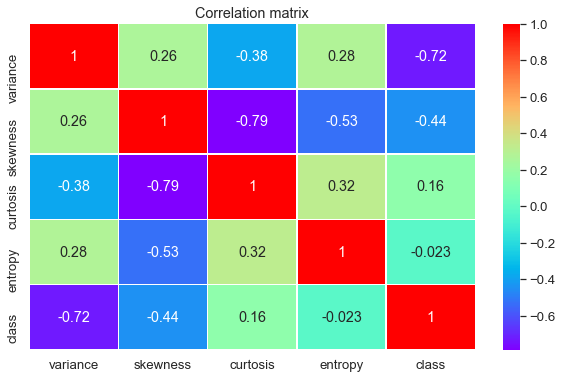

In [5]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(),annot=True, cmap='rainbow',linewidth=0.5)
plt.title('Correlation matrix');

In [6]:
# Choose attribute columns and class column.
X=df[df.columns[:-1]]
y=df['class']

y = np.array(y)
y = to_categorical(y)
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [7]:
#initializer0 = keras.initializers.RandomUniform(minval = -0.005, maxval =0)
#initializer1 = keras.initializers.RandomUniform(minval = -0.005, maxval =0)
#initializer2 = keras.initializers.RandomUniform(minval = 1, maxval =2)

initializer0 = keras.initializers.RandomUniform(minval = 0, maxval =0.005)
initializer1 = keras.initializers.RandomUniform(minval = 0, maxval =0.005)
initializer2 = keras.initializers.RandomUniform(minval = -2, maxval =-1)

class Diffact(keras.layers.Layer):
    def __init__(self):
        super(Diffact, self).__init__()
        self.k0 = self.add_weight(name='k0', shape = (), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape = (), initializer=initializer1, trainable=True)
        self.k2 = self.add_weight(name='k2', shape = (), initializer=initializer2, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1) + tf.multiply(tf.multiply(inputs,inputs), self.k2)

from keras import backend as K

class Mish(keras.layers.Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
# split data into train, test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=69, shuffle=True)
#kipping y since value already 1 or 0
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
'''
# normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
'''
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (df.columns)

(1234, 4) (1234, 2)
(138, 4) (138, 2)
Index(['variance', 'skewness', 'curtosis', 'entropy', 'class'], dtype='object')


In [9]:
# create model with fully connected layers with dropout regulation
model = Sequential()
model.add(layers.Dense(10, input_dim=4))
diffact=Diffact()
model.add(diffact)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
diffact (Diffact)            (None, 10)                3         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


In [10]:
batch_size = 5
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

log_dir = "banklogs/smallk1k0/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1 ,callbacks=[tensorboard_callback], verbose=1)


Epoch 1/100
  1/222 [..............................] - ETA: 0s - loss: 123.8843 - accuracy: 0.6000WARNING:tensorflow:From C:\Users\shamb\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
222/222 [==============================] - 0s 1ms/step - loss: 10.3391 - accuracy: 0.5108 - val_loss: 1.5103 - val_accuracy: 0.6774
Epoch 2/100
222/222 [==============================] - 0s 606us/step - loss: 1.6107 - accuracy: 0.7505 - val_loss: 0.5401 - val_accuracy: 0.8710
Epoch 3/100
222/222 [==============================] - 0s 644us/step - loss: 0.8667 - accuracy: 0.8378 - val_loss: 0.2242 - val_accuracy: 0.9355
Epoch 4/100
222/222 [==============================] - 0s 617us/step - loss: 0.5234 - accuracy: 0.8847 - val_loss: 0.1065 - val_accuracy: 0.9516
Epoch 5/100
222/222 [==============================] 

222/222 [==============================] - 0s 598us/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 6.7742e-04 - val_accuracy: 1.0000
Epoch 54/100
222/222 [==============================] - 0s 580us/step - loss: 0.0132 - accuracy: 0.9982 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 55/100
222/222 [==============================] - 0s 613us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 56/100
222/222 [==============================] - 0s 624us/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 5.9271e-04 - val_accuracy: 1.0000
Epoch 57/100
222/222 [==============================] - 0s 593us/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 58/100
222/222 [==============================] - 0s 641us/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 8.6296e-04 - val_accuracy: 1.0000
Epoch 59/100
222/222 [==============================] - 0s 600us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.9893e-0

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0001187960006063804
Test accuracy: 1.0


In [12]:
print("AF coefficients (weights) {}".format(diffact.get_weights()))

AF coefficients (weights) [1.6777613, -0.21792224, -1.3766757]


In [15]:
%tensorboard --logdir banklogs/smallk1k0 --port=6030

Reusing TensorBoard on port 6030 (pid 21024), started 0:00:58 ago. (Use '!kill 21024' to kill it.)

In [14]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000
